In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sys 
#pahn1: ket noi mysql
DB_HOST = "localhost"
DB_USER = "root"
DB_PASS = "180605" #
DB_NAME = "review_crawl"


print("Đang kết nối tới MySQL...")
try:
    db_connection_str = f'mysql+mysqlconnector://{DB_USER}:{DB_PASS}@{DB_HOST}/{DB_NAME}'
    engine = create_engine(db_connection_str) 
    print("Kết nối thành công! Biến 'engine' đã sẵn sàng.")
except Exception as e:
    print(f"LỖI KẾT NỐI: {e}")
    sys.exit() 

sns.set_style("whitegrid")



# PHẦN 2: TẢI DỮ LIỆU T

print("BƯỚC 2: TẢI DỮ LIỆU THÔ (Cả 2 đợt)")

try:
    print(" -> Đang tải Đợt 1 (từ _dot_1)...")
    
    df_products_t7 = pd.read_sql('SELECT * FROM products_dot_7', con=engine)
    
    df_reviews_t7 = pd.read_sql('SELECT * FROM reviews_dot_7', con=engine)
    print("Đợt 1: Tải thành công 2 bảng thô.")

except Exception as e:
    print(f"LỖI KHI TẢI ĐỢT 1: {e}")
    sys.exit() 

try:
    print("\n -> Đang tải Đợt 2 (từ _dot_2)...") 

    df_products_t8 = pd.read_sql('SELECT * FROM products_dot_8', con=engine)
    
    df_reviews_t8 = pd.read_sql('SELECT * FROM reviews_dot_8', con=engine)
    
    print(f" -> df_products_t7: {len(df_products_t7)} hàng")
    print(f" -> df_reviews_t7:  {len(df_reviews_t7)} hàng")
    print(f" -> df_products_t8: {len(df_products_t8)} hàng")
    print(f" -> df_reviews_t8:  {len(df_reviews_t8)} hàng")

except Exception as e:
    print(f"LỖI KHI TẢI ĐỢT 2: {e}")
    sys.exit()

Đang kết nối tới MySQL...
Kết nối thành công! Biến 'engine' đã sẵn sàng.
BƯỚC 2: TẢI DỮ LIỆU THÔ (Cả 2 đợt)
 -> Đang tải Đợt 1 (từ _dot_1)...
Đợt 1: Tải thành công 2 bảng thô.

 -> Đang tải Đợt 2 (từ _dot_2)...
 -> df_products_t7: 92 hàng
 -> df_reviews_t7:  191235 hàng
 -> df_products_t8: 88 hàng
 -> df_reviews_t8:  204615 hàng


In [2]:


print("\nBƯỚC 3 (v2): LỌC (INNER JOIN) VÀ XÓA TRÙNG LẶP")

print(" -> 3.1: Đang dọn dẹp Keys (Link và ID)...")
LINK_COLUMN_NAME = 'link' 


df_products_t7[LINK_COLUMN_NAME] = df_products_t7[LINK_COLUMN_NAME].astype(str).str.strip()
df_products_t7['product_id'] = pd.to_numeric(df_products_t7['product_id'], errors='coerce').fillna(0).astype(int).astype(str)
df_reviews_t7['product_id'] = pd.to_numeric(df_reviews_t7['product_id'], errors='coerce').fillna(0).astype(int).astype(str)


df_products_t8[LINK_COLUMN_NAME] = df_products_t8[LINK_COLUMN_NAME].astype(str).str.strip()
df_products_t8['product_id'] = pd.to_numeric(df_products_t8['product_id'], errors='coerce').fillna(0).astype(int).astype(str)
df_reviews_t8['product_id'] = pd.to_numeric(df_reviews_t8['product_id'], errors='coerce').fillna(0).astype(int).astype(str)
print(" -> 3.1: Dọn dẹp Keys hoàn tất.")

# --- 3.2: Xóa trùng lặp Link (SỬA LỖI) ---
print(" -> 3.2: Đang xóa các link trùng lặp (chỉ giữ lại 1)...")
# Giữ lại 'link' đầu tiên nó thấy
df_products_t7.drop_duplicates(subset=[LINK_COLUMN_NAME], keep='first', inplace=True)
df_products_t8.drop_duplicates(subset=[LINK_COLUMN_NAME], keep='first', inplace=True)
print(f" -> df_products_t7 (sạch): {len(df_products_t7)} hàng")
print(f" -> df_products_t8 (sạch): {len(df_products_t8)} hàng")


# --- 3.3: Tìm danh sách Link chung ---
print(" -> 3.3: Đang tìm các link chung...")
links_t7 = set(df_products_t7[LINK_COLUMN_NAME])
links_t8 = set(df_products_t8[LINK_COLUMN_NAME])

common_links = links_t7.intersection(links_t8)
print(f" -> 3.3: Tìm thấy {len(common_links)} link chung ở cả hai đợt.")

# --- 3.4: Lọc các bảng Products (Bây giờ sẽ khớp) ---
print(" -> 3.4: Đang lọc các bảng Products...")
df_products_t7 = df_products_t7[df_products_t7[LINK_COLUMN_NAME].isin(common_links)].copy()
df_products_t8 = df_products_t8[df_products_t8[LINK_COLUMN_NAME].isin(common_links)].copy()

print(f" -> df_products_t7 (mới): {len(df_products_t7)} hàng")
print(f" -> df_products_t8 (mới): {len(df_products_t8)} hàng")

# --- 3.5: Lọc các bảng Reviews (Bây giờ sẽ hoạt động) ---
print(" -> 3.5: Đang lọc các bảng Reviews...")
valid_ids_t7 = set(df_products_t7['product_id'])
valid_ids_t8 = set(df_products_t8['product_id'])

df_reviews_t7 = df_reviews_t7[df_reviews_t7['product_id'].isin(valid_ids_t7)].copy()
df_reviews_t8 = df_reviews_t8[df_reviews_t8['product_id'].isin(valid_ids_t8)].copy()

print(f" -> df_reviews_t7 (mới): {len(df_reviews_t7)} hàng")
print(f" -> df_reviews_t8 (mới): {len(df_reviews_t8)} hàng")

print("\n. Các bảng đã được đồng bộ.")


BƯỚC 3 (v2): LỌC (INNER JOIN) VÀ XÓA TRÙNG LẶP
 -> 3.1: Đang dọn dẹp Keys (Link và ID)...
 -> 3.1: Dọn dẹp Keys hoàn tất.
 -> 3.2: Đang xóa các link trùng lặp (chỉ giữ lại 1)...
 -> df_products_t7 (sạch): 92 hàng
 -> df_products_t8 (sạch): 81 hàng
 -> 3.3: Đang tìm các link chung...
 -> 3.3: Tìm thấy 81 link chung ở cả hai đợt.
 -> 3.4: Đang lọc các bảng Products...
 -> df_products_t7 (mới): 81 hàng
 -> df_products_t8 (mới): 81 hàng
 -> 3.5: Đang lọc các bảng Reviews...
 -> df_reviews_t7 (mới): 166029 hàng
 -> df_reviews_t8 (mới): 187683 hàng

. Các bảng đã được đồng bộ.


In [3]:

# BƯỚC 4: TẠO DATAFRAME TỔNG HỢP (df_analysis)

#  gộp dựa trên 'link' 



#laycuabang7
products_t7_simple = df_products_t7[
    ['link', 'product_id', 'title', 'avg_rate', 'review_count']
].copy()

# Đổi tên cột để chuẩn bị gộp
products_t7_simple = products_t7_simple.rename(columns={
    'avg_rate': 'avg_rate_t7',
    'review_count': 'review_count_7'
})

# --- 4.2: Chuẩn bị bảng T8 ---
# Lấy các cột bạn cần từ T8 (chỉ cần 'link' và 'review_count')
products_t8_simple = df_products_t8[
    ['link', 'review_count']
].copy()

# Đổi tên cột
products_t8_simple = products_t8_simple.rename(columns={
    'review_count': 'review_count_8'
})

# Merge T7 và T8
df_analysis = pd.merge(products_t7_simple, products_t8_simple, on='link', how='inner')
print(f"     Gộp bảng hoàn tất! 'df_analysis' có {len(df_analysis)} hàng.")

#  Tính toán chênh lệch 
print(" -> 4.4: Đang tính 'review_count_diff'...")
df_analysis['review_count_diff'] = df_analysis['review_count_8'] - df_analysis['review_count_7']
print("     Đã tính xong độ chênh lệch review.")

# --- HOÀN TẤT ---
print("\nBƯỚC 4 HOÀN TẤT!")
print("     DataFrame 'df_analysis' đã sẵn sàng (5 dòng đầu):")

# Hiển thị các cột cuối cùng
final_columns = [
    'product_id',  # (Sẽ là ID từ Đợt 7)
    'title', 
    'link', 
    'avg_rate_t7', 
    'review_count_7', 
    'review_count_8', 
    'review_count_diff'
]
print(df_analysis[final_columns].head())

     Gộp bảng hoàn tất! 'df_analysis' có 81 hàng.
 -> 4.4: Đang tính 'review_count_diff'...
     Đã tính xong độ chênh lệch review.

BƯỚC 4 HOÀN TẤT!
     DataFrame 'df_analysis' đã sẵn sàng (5 dòng đầu):
  product_id                                              title  \
0          1  ((X) Sao Nhựa Và Sang Trọng Nút Dép Nút Trang ...   
1          2  (Form to đặt lùi 1 size) Giày sandal gắn hoạ t...   
2          3  (FREE-SHIP) Dép lê DSQ Cao Cấp, Dòng Dép Lê Qu...   
3          4  (FREE-SHIP) Dép Nam Cao Cấp, Dòng Dép Lê Quai ...   
4          5  (Lùi 1 size) Dép Rabbit Town quai dán xé cute ...   

                                                link  avg_rate_t7  \
0  https://shopee.vn/((X)-Sao-Nh%E1%BB%B1a-V%C3%A...       4.0000   
1  https://shopee.vn/(Form-to-%C4%91%E1%BA%B7t-l%...       4.5182   
2  https://shopee.vn/(FREE-SHIP)-D%C3%A9p-l%C3%AA...       4.6521   
3  https://shopee.vn/(FREE-SHIP)-D%C3%A9p-Nam-Cao...       4.5010   
4  https://shopee.vn/(L%C3%B9i-1-size)-D%C3%A9p

In [4]:

print(df_analysis.head())


                                                link product_id  \
0  https://shopee.vn/((X)-Sao-Nh%E1%BB%B1a-V%C3%A...          1   
1  https://shopee.vn/(Form-to-%C4%91%E1%BA%B7t-l%...          2   
2  https://shopee.vn/(FREE-SHIP)-D%C3%A9p-l%C3%AA...          3   
3  https://shopee.vn/(FREE-SHIP)-D%C3%A9p-Nam-Cao...          4   
4  https://shopee.vn/(L%C3%B9i-1-size)-D%C3%A9p-R...          5   

                                               title  avg_rate_t7  \
0  ((X) Sao Nhựa Và Sang Trọng Nút Dép Nút Trang ...       4.0000   
1  (Form to đặt lùi 1 size) Giày sandal gắn hoạ t...       4.5182   
2  (FREE-SHIP) Dép lê DSQ Cao Cấp, Dòng Dép Lê Qu...       4.6521   
3  (FREE-SHIP) Dép Nam Cao Cấp, Dòng Dép Lê Quai ...       4.5010   
4  (Lùi 1 size) Dép Rabbit Town quai dán xé cute ...       4.6933   

   review_count_7  review_count_8  review_count_diff  
0             786             790                  4  
1            2358            2580                222  
2            2633

In [5]:
# Lọc các sản phẩm có review_count_diff = 0
df_zero_diff = df_analysis[df_analysis['review_count_diff'] == 0]

# Hiển thị các cột cần thiết
df_zero_diff[['product_id', 'title', 'link',
              'review_count_7', 'review_count_8', 
              'review_count_diff',
              'avg_rate_t7']]


,product_id,title,link,review_count_7,review_count_8,review_count_diff,avg_rate_t7
9,13,Cross Jibbicz Miếng Dán Quyến Rũ A-Z Chữ Và Số...,https://shopee.vn/Cross-Jibbicz-Mi%E1%BA%BFng-...,3006,3006,0,3.3333
17,21,Dép Cross Nam Baya - Dép Crocs Sục Size Người ...,https://shopee.vn/D%C3%A9p-Cross-Nam-Baya-D%C3...,3006,3006,0,4.7585
22,26,"dép lê nữ , dép m.in đế mềm êm chân may viền t...",https://shopee.vn/d%C3%A9p-l%C3%AA-n%E1%BB%AF-...,3006,3006,0,4.7611
37,41,Dép sandal nữ đế cao 7cm đính kèm nhiều sticke...,https://shopee.vn/D%C3%A9p-sandal-n%E1%BB%AF-%...,3006,3006,0,3.0818
38,42,Dép sandal nữ đế cao quai da mềm đính khuy chắ...,https://shopee.vn/D%C3%A9p-sandal-n%E1%BB%AF-%...,3006,3006,0,4.7502
58,65,"Giày thể thao Onit. Tiiger Tokten White Black,...",https://shopee.vn/Gi%C3%A0y-th%E1%BB%83-thao-O...,36,36,0,4.3889
67,76,Miếng Dán Chống Trượt Đế Cuộn 1M / Cuộn - Thảm...,https://shopee.vn/Mi%E1%BA%BFng-D%C3%A1n-Ch%E1...,3006,3006,0,4.5293
73,82,[Bestquality] Giày Champion Essentials Champ ...,https://shopee.vn/-Bestquality-Gia%CC%80y-Cham...,37,37,0,3.5676


In [6]:
# Xóa các sản phẩm có review_count_7 = review_count_8 = 3006
df_analysis = df_analysis[~((df_analysis['review_count_7'] == 3006) & 
                            (df_analysis['review_count_8'] == 3006))]

# Kiểm tra lại xem còn sản phẩm nào như vậy không
df_analysis[(df_analysis['review_count_7'] == 3006) & 
            (df_analysis['review_count_8'] == 3006)]


,link,product_id,title,avg_rate_t7,review_count_7,review_count_8,review_count_diff


 ->Tính toán ma trận tương quan 
Ma trận tương quan:
                   avg_rate_t7  review_count_7  review_count_8  \
avg_rate_t7           1.000000        0.244454        0.320599   
review_count_7        0.244454        1.000000        0.981568   
review_count_8        0.320599        0.981568        1.000000   
review_count_diff     0.460536        0.188582        0.372790   

                   review_count_diff  
avg_rate_t7                 0.460536  
review_count_7              0.188582  
review_count_8              0.372790  
review_count_diff           1.000000  


 -> heatmap 


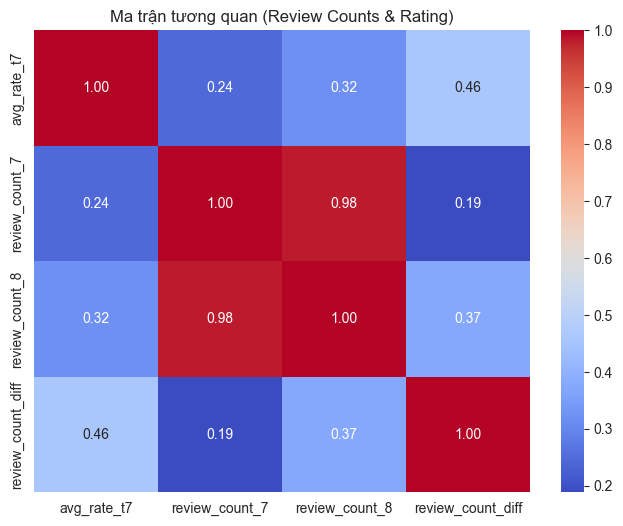

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

print(" ->Tính toán ma trận tương quan ")

# Chọn các cột số liên quan từ df_analysis MỚI
corr_df = df_analysis[[
    'avg_rate_t7', 
    'review_count_7', 
    'review_count_8', 
    'review_count_diff'
]]
correlation_matrix = corr_df.corr()

print("Ma trận tương quan:")
print(correlation_matrix)
print("\n")

# --- PHẦN 6.2: Trực quan hóa (Heatmap) ---
print(" -> heatmap ")

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Ma trận tương quan (Review Counts & Rating)')


plt.show()

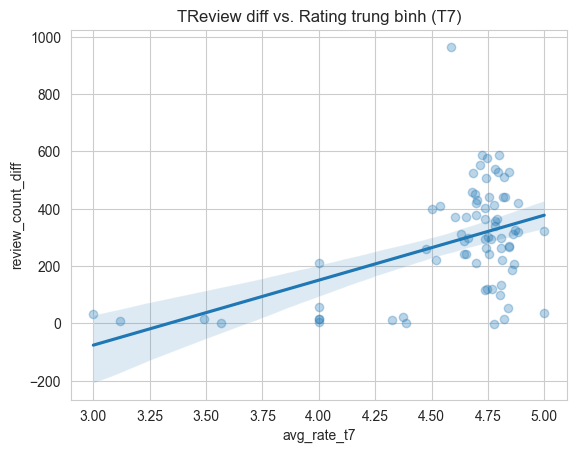

In [8]:
# Dùng regplot để vẽ đường xu hướng
sns.regplot(data=df_analysis, x='avg_rate_t7', y='review_count_diff', 
            scatter_kws={'alpha':0.3})
plt.title('TReview diff vs. Rating trung bình (T7)')
plt.show()

In [16]:
from scipy import stats

print(" Bước 1 - Kiểm định T (T-test) ")


# Nhóm 1: 
nhom_rating_cao = df_analysis[df_analysis['avg_rate_t7'] >= 4.5]['review_count_diff']

# Nhóm 2: 
nhom_rating_thap = df_analysis[df_analysis['avg_rate_t7'] < 4.5]['review_count_diff']

print(f"Đã tạo 2 nhóm:")
print(f" - Nhóm Rating Cao (>= 4.5): {len(nhom_rating_cao)} sản phẩm")
print(f" - Nhóm Rating Thấp (< 4.5):  {len(nhom_rating_thap)} sản phẩm")

print(f"\nRating cao có 'review_count_diff' TB: {nhom_rating_cao.mean():.2f}")
print(f"Rating thấp có 'review_count_diff' TB: {nhom_rating_thap.mean():.2f}")

# 2. Thực hiện T-test
# Dùng 'alternative='greater'' để kiểm tra giả thuyết 1 chiều (cao > thấp)
t_statistic, p_value = stats.ttest_ind(
    nhom_rating_cao, 
    nhom_rating_thap, 
    equal_var=False,         # Giả định phương sai không bằng nhau
    alternative='greater'    #  Một phía (phải) → kiểm tra “nhóm 1 có LỚN HƠN nhóm 2 không”
)

print("\n--- KẾT QUẢ T-TEST ---")
print(f"T-Statistic: {t_statistic:.4f}")
print(f"P-Value: {p_value:.3e}")

# 3. Diễn giải kết quả
alpha = 0.05  # Mức ý nghĩa 5%
if p_value < alpha:
    print("\nKết luận: P-value < 0.05. Bác bỏ giả thuyết H0.")
    print(" -> Có bằng chứng thống kê cho thấy các sản phẩm rating cao (>=4.5) có mức tăng trưởng review trung bình CAO HƠN các sản phẩm rating thấp.")
else:
    print("\n Kết luận: P-value >= 0.05. Không đủ bằng chứng bác bỏ giả thuyết H0.")
    print(" -> Không có sự khác biệt có ý nghĩa thống kê về 'review_count_diff' trung bình giữa hai nhóm.")

 Bước 1 - Kiểm định T (T-test) 
Đã tạo 2 nhóm:
 - Nhóm Rating Cao (>= 4.5): 62 sản phẩm
 - Nhóm Rating Thấp (< 4.5):  13 sản phẩm

Rating cao có 'review_count_diff' TB: 338.71
Rating thấp có 'review_count_diff' TB: 50.31

--- KẾT QUẢ T-TEST ---
T-Statistic: 9.1463
P-Value: 3.614e-11

Kết luận: P-value < 0.05. Bác bỏ giả thuyết H0.
 -> Có bằng chứng thống kê cho thấy các sản phẩm rating cao (>=4.5) có mức tăng trưởng review trung bình CAO HƠN các sản phẩm rating thấp.


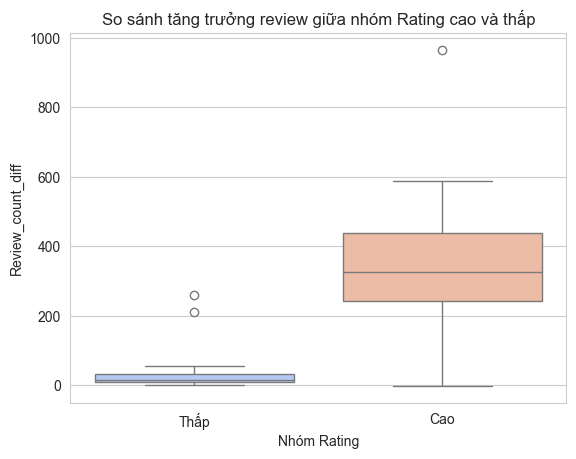

In [20]:
sns.boxplot(
    x='group',
    y='review_count_diff',
    data=df_analysis,
    hue='group',          # thêm hue để tránh cảnh báo
    palette='coolwarm',
    dodge=False
)
df_analysis['group'] = np.where(df_analysis['avg_rate_t7'] >= 4.5, 'Cao', 'Thấp')

# Ẩn legend vì nhãn nhóm đã hiển thị ở trục X
plt.legend([], [], frameon=False)

# Tiêu đề và nhãn
plt.title('So sánh tăng trưởng review giữa nhóm Rating cao và thấp')
plt.xlabel('Nhóm Rating')
plt.ylabel('Review_count_diff')

# Hiển thị biểu đồ
plt.show()

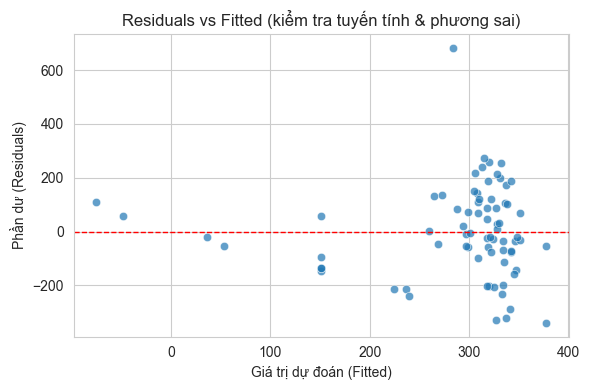

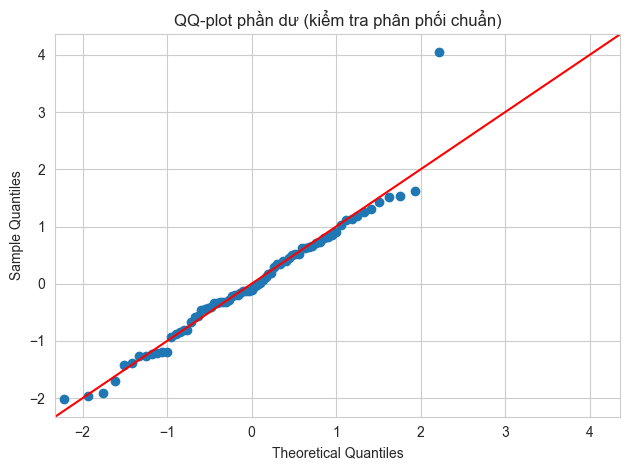

Breusch–Pagan test: p-value = 0.4805  (p<0.05 → có heteroskedasticity)
Shapiro–Wilk test: p-value = 0.0167  (p<0.05 → phần dư lệch chuẩn)
                            OLS Regression Results                            
Dep. Variable:      review_count_diff   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     19.65
Date:                Wed, 12 Nov 2025   Prob (F-statistic):           3.22e-05
Time:                        22:23:15   Log-Likelihood:                -490.75
No. Observations:                  75   AIC:                             985.5
Df Residuals:                      73   BIC:                             990.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025     

In [ ]:
# ==== IMPORT CẦN THIẾT ====
import seaborn as sns                      # để vẽ biểu đồ
import matplotlib.pyplot as plt             # để hiển thị đồ thị
import statsmodels.api as sm                # để hồi quy tuyến tính OLS
from statsmodels.stats.diagnostic import het_breuschpagan   # kiểm định phương sai không đổi
from scipy.stats import shapiro                              # kiểm định chuẩn hóa phần dư

# ==== 1️⃣ FIT MÔ HÌNH HỒI QUY ====
# X: biến độc lập (rating trung bình)
# y: biến phụ thuộc (mức tăng review)
X = df_analysis[['avg_rate_t7']]
y = df_analysis['review_count_diff']

# Thêm hệ số chặn (const = b0)
X = sm.add_constant(X)

# Tạo mô hình hồi quy tuyến tính và huấn luyện
model = sm.OLS(y, X).fit()

# ==== 2️⃣ LẤY PHẦN DƯ & GIÁ TRỊ DỰ ĐOÁN ====
y_hat = model.fittedvalues   # Giá trị mô hình dự đoán
resid  = model.resid         # Sai số (y_thực - y_dự đoán)

# ==== 3️⃣ KIỂM TRA TUYẾN TÍNH & PHƯƠNG SAI ====
plt.figure(figsize=(6,4))
sns.scatterplot(x=y_hat, y=resid, alpha=0.7)
plt.axhline(0, color='red', ls='--', lw=1)
plt.xlabel('Giá trị dự đoán (Fitted)')
plt.ylabel('Phần dư (Residuals)')
plt.title('Residuals vs Fitted (kiểm tra tuyến tính & phương sai)')
plt.tight_layout()
plt.show()

#  Nếu các điểm rải đều quanh đường 0 → quan hệ tuyến tính và phương sai đồng nhất
#  Nếu có hình cong hoặc phễu → mô hình vi phạm tuyến tính hoặc phương sai thay đổi

# ==== 4️⃣ KIỂM TRA CHUẨN HOÁ PHẦN DƯ (QQ-PLOT) ====
sm.qqplot(resid, line='45', fit=True)
plt.title('QQ-plot phần dư (kiểm tra phân phối chuẩn)')
plt.tight_layout()
plt.show()

#  Nếu các điểm bám sát đường chéo → phần dư có phân phối chuẩn (OK)
#  Nếu lệch nhiều → phần dư lệch chuẩn (cần xem xét robust SE hoặc biến đổi log)

# ==== 5️⃣ KIỂM TRA PHƯƠNG SAI KHÔNG ĐỔI (Breusch–Pagan) ====
bp_stat, bp_pvalue, _, _ = het_breuschpagan(resid, model.model.exog)
print(f"Breusch–Pagan test: p-value = {bp_pvalue:.4f}  (p<0.05 → có heteroskedasticity)")

# Nếu p > 0.05 → phương sai không đổi (OK)
#  Nếu p < 0.05 → phương sai thay đổi (nên dùng robust SE)

# ==== 6️⃣ KIỂM TRA CHUẨN HOÁ PHẦN DƯ (Shapiro–Wilk) ====
shapiro_p = shapiro(resid)[1]
print(f"Shapiro–Wilk test: p-value = {shapiro_p:.4f}  (p<0.05 → phần dư lệch chuẩn)")

#  Nếu p > 0.05 → phần dư có phân phối chuẩn (OK)
#  Nếu p < 0.05 → phần dư lệch chuẩn (nên dùng robust SE hoặc log-transform Y)

# ==== 7️⃣ IN KẾT QUẢ MÔ HÌNH ====
print(model.summary())

# => model.summary() hiển thị:
#    - R-squared: mức độ giải thích của mô hình (cao hơn → tốt hơn)
#    - coef: hệ số hồi quy (avg_rate_t7 dương → rating tăng → review tăng)
#    - P>|t|: kiểm tra ý nghĩa thống kê của từng biến (p < 0.05 → có ý nghĩa)
#    - Durbin–Watson ≈ 2 → phần dư độc lập (không tự tương quan)


Mô hình hồi quy tuyến tính giữa avg_rate_t7 (rating trung bình) và review_count_diff (số review tăng) cho kết quả:

Hệ số hồi quy = 226.54, P-value = 0.000

Nghĩa là mỗi khi rating trung bình tăng 1 điểm, số review trung bình tăng thêm khoảng 226 lượt.

P-value < 0.05 ⇒ Mối quan hệ này có ý nghĩa thống kê.

R² = 0.212 ⇒ Rating trung bình giải thích được khoảng 21% sự thay đổi trong lượng review tăng.

Kết luận: Rating trung bình có ảnh hưởng tích cực và có ý nghĩa thống kê đến sự tăng trưởng số lượng review, củng cố kết quả từ phần T-test và Heatmap trước đó.

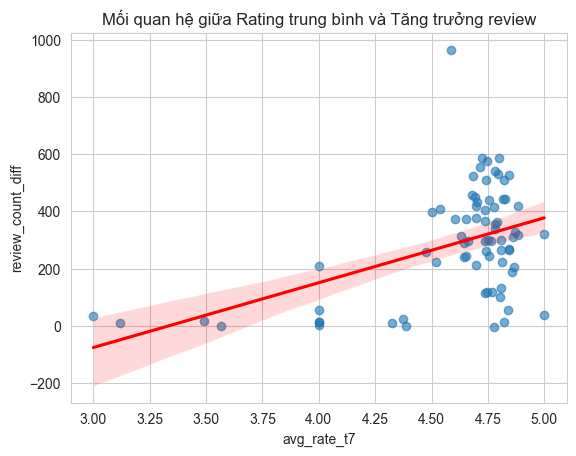

In [24]:
sns.regplot(
    x='avg_rate_t7',
    y='review_count_diff',
    data=df_analysis,
    line_kws={'color':'red'},
    scatter_kws={'alpha':0.6}
)
plt.title('Mối quan hệ giữa Rating trung bình và Tăng trưởng review')
plt.show()
